# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt

In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_consumer_good data paths
    lst_df_consumer_good_paths = ast.literal_eval(config.get("paths_df_consumer_good_processed"))
    

In [4]:
# Import data 
path = lst_df_consumer_good_paths[2]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_DBC,adClose_DLG,adClose_HHS,adClose_HNG,adClose_IDI,adClose_SBT,adClose_TNG,adClose_TSC,adClose_TTF,adClose_VNM
date,,,,,,,,,,
2021-11-30,37.286,7.00,9.695,8.82,21.887,20.814,24.157,16.630,11.60,79.234
2021-12-01,37.144,7.16,9.497,8.89,20.400,21.069,25.583,16.720,11.35,79.144
2021-12-02,37.239,7.66,9.458,9.00,19.006,21.069,25.028,16.450,11.35,79.053
2021-12-03,35.667,7.20,8.825,8.60,17.705,20.092,24.474,15.326,11.10,77.606
2021-12-04,35.667,7.20,8.825,8.60,17.705,20.092,24.474,15.326,11.10,77.606
...,...,...,...,...,...,...,...,...,...,...
2023-02-16,14.450,2.15,3.871,4.28,12.400,13.409,16.735,3.640,4.39,74.037
2023-02-17,14.300,2.15,3.991,4.27,12.150,13.455,16.273,3.600,4.38,73.553
2023-02-18,14.300,2.15,3.991,4.27,12.150,13.455,16.273,3.600,4.38,73.553


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_DBC,adClose_DLG,adClose_HHS,adClose_HNG,adClose_IDI,adClose_SBT,adClose_TNG,adClose_TSC,adClose_TTF,adClose_VNM
date,,,,,,,,,,
2021-12-01,-0.380840,2.285714,-2.042290,0.793651,-6.793987,1.225137,5.903051,0.541191,-2.155172,-0.113588
2021-12-02,-0.126053,9.428571,-2.444559,2.040816,-13.163065,1.225137,3.605580,-1.082381,-2.155172,-0.228437
2021-12-03,-4.342112,2.857143,-8.973698,-2.494331,-19.107233,-3.468819,1.312249,-7.841251,-4.310345,-2.054673
2021-12-04,-4.342112,2.857143,-8.973698,-2.494331,-19.107233,-3.468819,1.312249,-7.841251,-4.310345,-2.054673
2021-12-05,-4.342112,2.857143,-8.973698,-2.494331,-19.107233,-3.468819,1.312249,-7.841251,-4.310345,-2.054673
...,...,...,...,...,...,...,...,...,...,...
2023-02-16,-61.245508,-69.285714,-60.072202,-51.473923,-43.345365,-35.577015,-30.724014,-78.111846,-62.155172,-6.559053
2023-02-17,-61.647803,-69.285714,-58.834451,-51.587302,-44.487595,-35.356010,-32.636503,-78.352375,-62.241379,-7.169902
2023-02-18,-61.647803,-69.285714,-58.834451,-51.587302,-44.487595,-35.356010,-32.636503,-78.352375,-62.241379,-7.169902


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_DBC và adClose_DLG: 320.9
Khoảng cách Euclide của adClose_DBC và adClose_HHS: 169.6
Khoảng cách Euclide của adClose_DBC và adClose_SBT: 247.1
Khoảng cách Euclide của adClose_DLG và adClose_HHS: 185.8
Khoảng cách Euclide của adClose_DLG và adClose_HNG: 293.7
Khoảng cách Euclide của adClose_HHS và adClose_HNG: 287.8
Khoảng cách Euclide của adClose_HHS và adClose_SBT: 299.7
Khoảng cách Euclide của adClose_HHS và adClose_TSC: 323.6
Khoảng cách Euclide của adClose_HNG và adClose_SBT: 297.5
Khoảng cách Euclide của adClose_HNG và adClose_TTF: 306.7
[['adClose_DBC', 'adClose_DLG'], ['adClose_DBC', 'adClose_HHS'], ['adClose_DBC', 'adClose_SBT'], ['adClose_DLG', 'adClose_HHS'], ['adClose_DLG', 'adClose_HNG'], ['adClose_HHS', 'adClose_HNG'], ['adClose_HHS', 'adClose_SBT'], ['adClose_HHS', 'adClose_TSC'], ['adClose_HNG', 'adClose_SBT'], ['adClose_HNG', 'adClose_TTF']]


In [15]:
gatev_pairs

[['adClose_DBC', 'adClose_DLG'],
 ['adClose_DBC', 'adClose_HHS'],
 ['adClose_DBC', 'adClose_SBT'],
 ['adClose_DLG', 'adClose_HHS'],
 ['adClose_DLG', 'adClose_HNG'],
 ['adClose_HHS', 'adClose_HNG'],
 ['adClose_HHS', 'adClose_SBT'],
 ['adClose_HHS', 'adClose_TSC'],
 ['adClose_HNG', 'adClose_SBT'],
 ['adClose_HNG', 'adClose_TTF']]

# **Cointegration Approach**

## **Data Transformation**

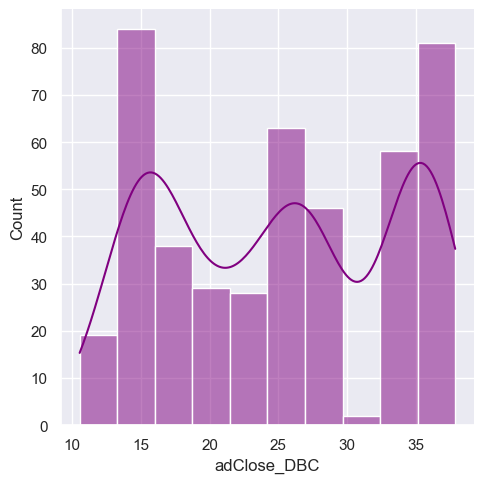

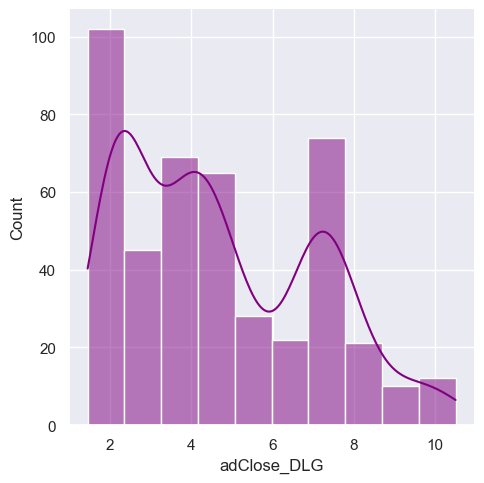

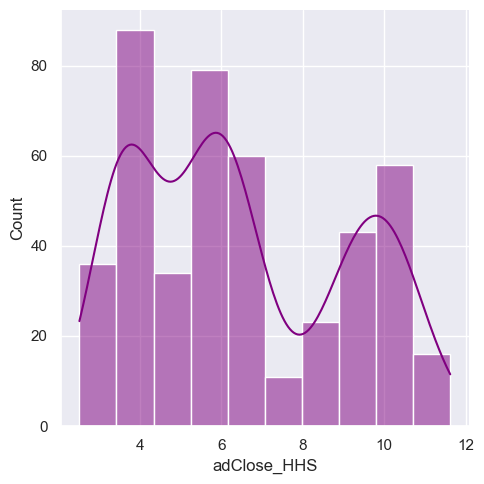

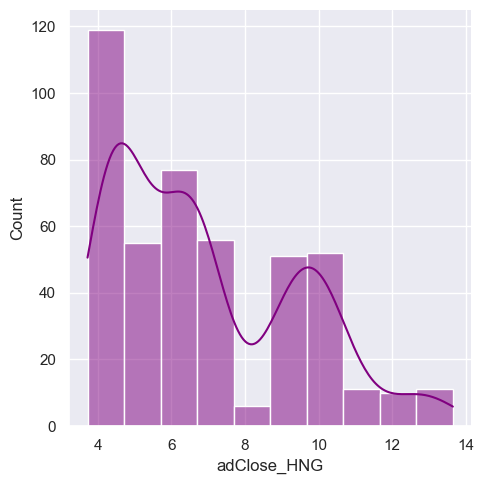

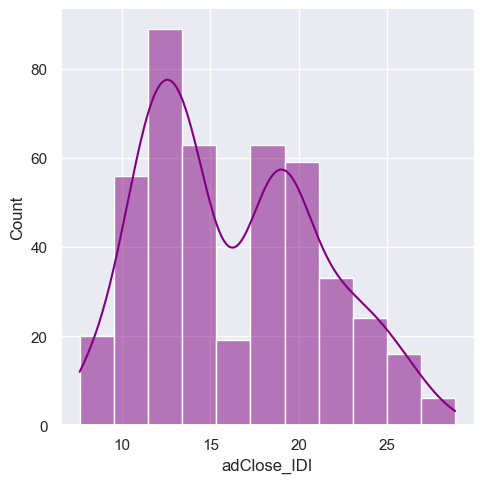

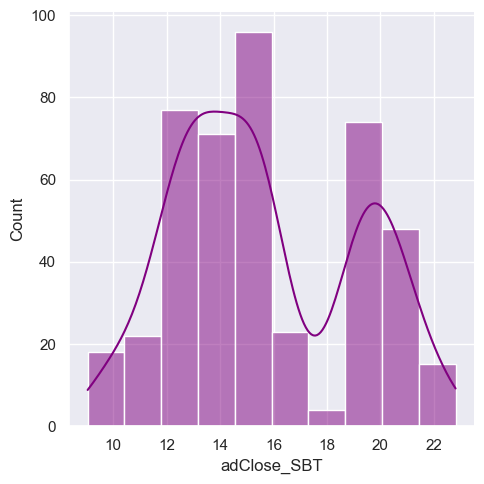

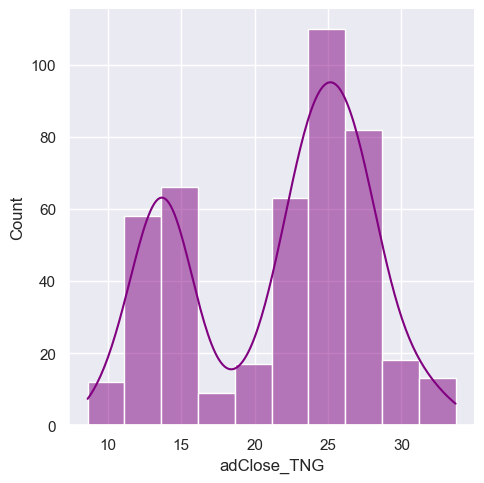

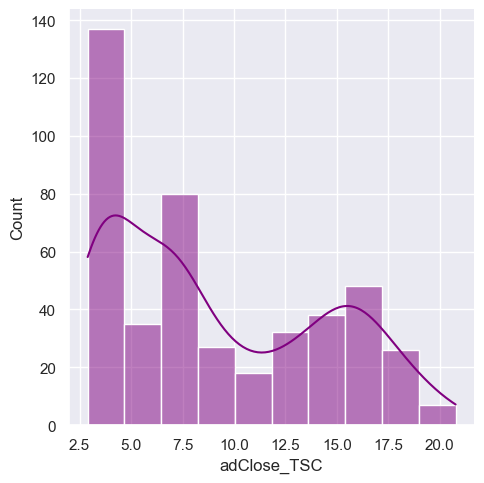

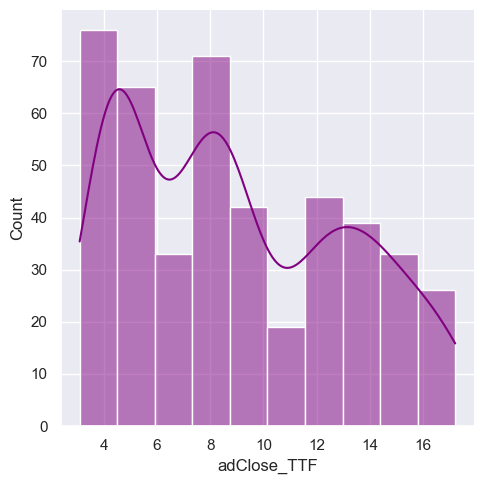

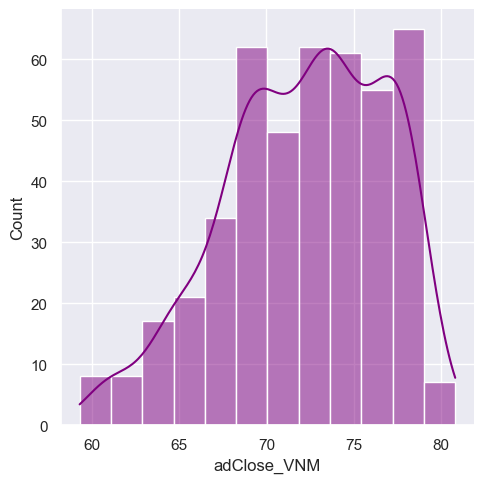

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_DBC,1
1,adClose_DLG,1
2,adClose_HHS,1
3,adClose_HNG,1
4,adClose_IDI,1
5,adClose_SBT,1
6,adClose_TNG,1
7,adClose_TSC,1
8,adClose_TTF,1
9,adClose_VNM,1


## **Engle - Grange Method**

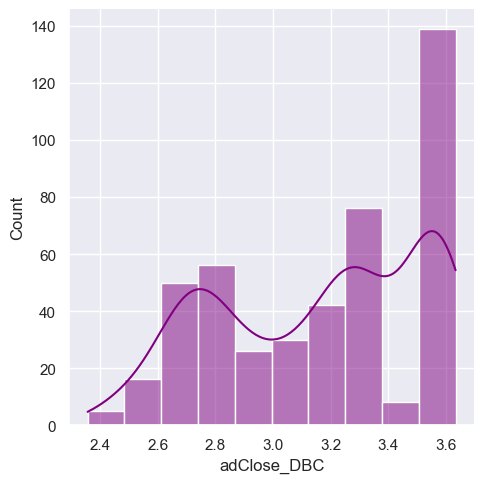

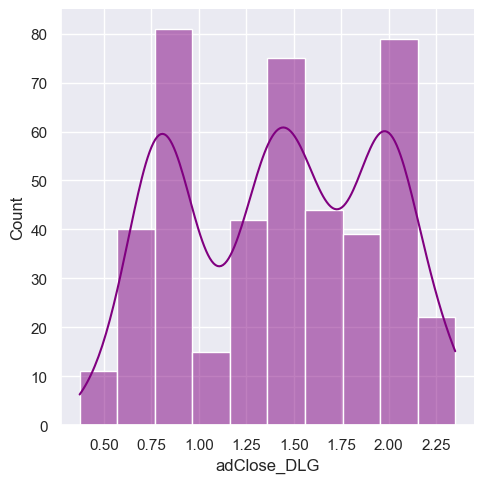

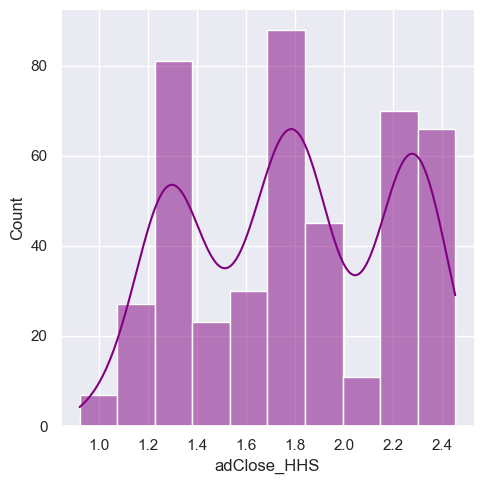

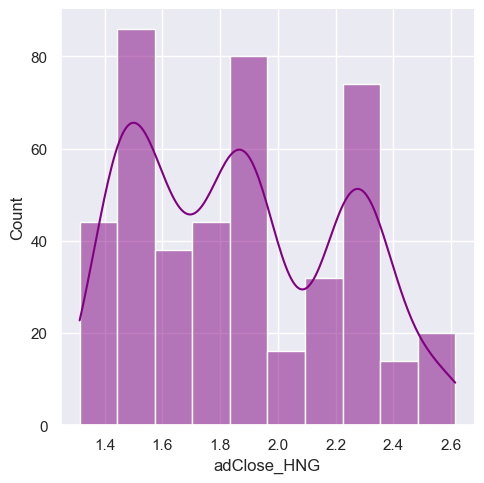

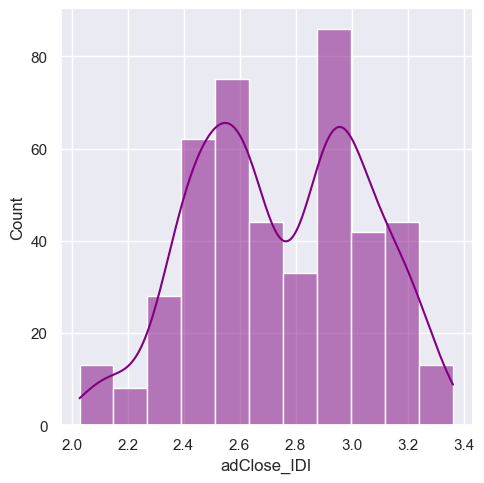

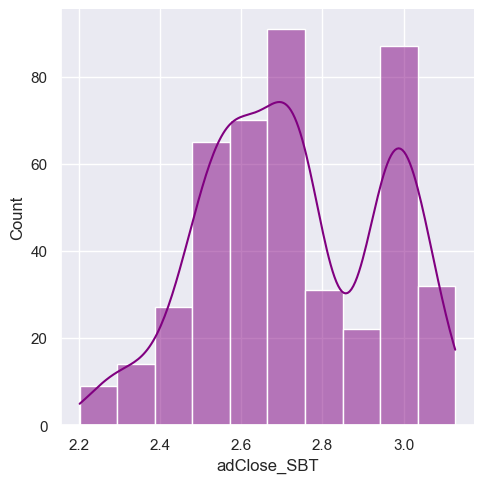

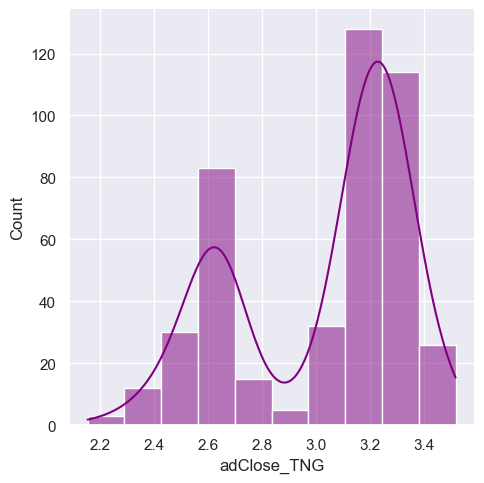

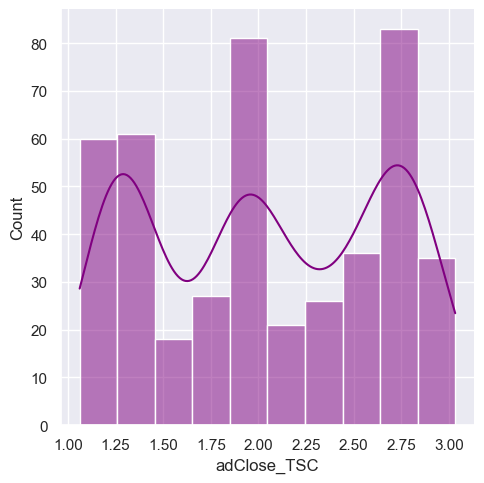

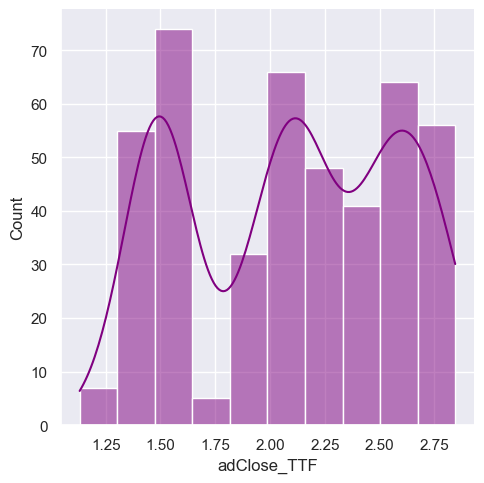

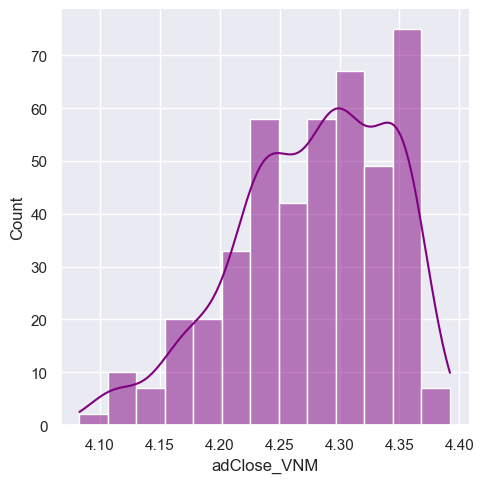

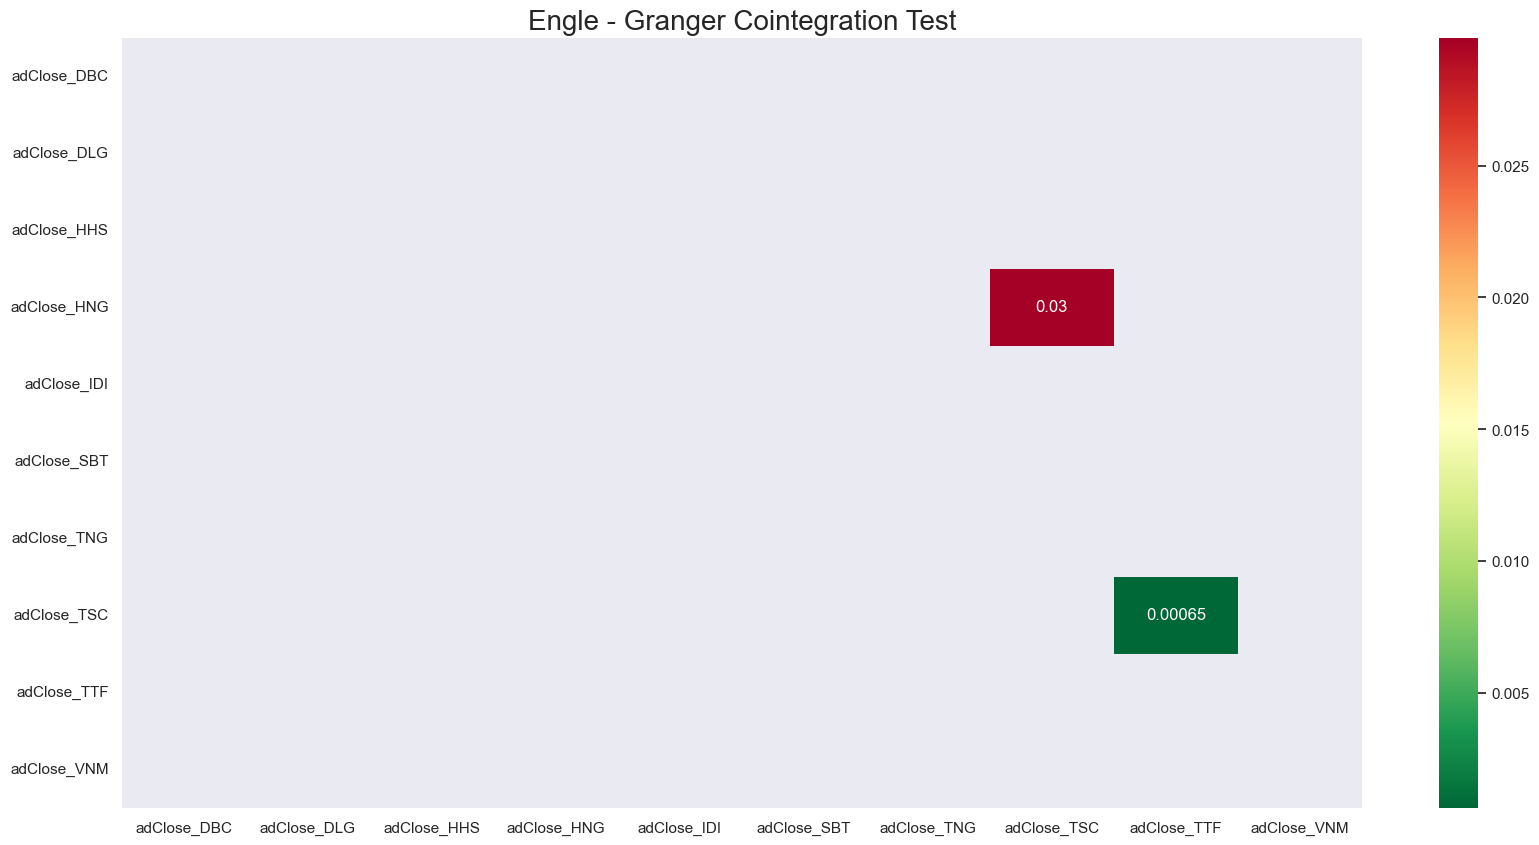

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [21]:
eg_pairs 

[['adClose_HNG', 'adClose_TSC'], ['adClose_TSC', 'adClose_TTF']]

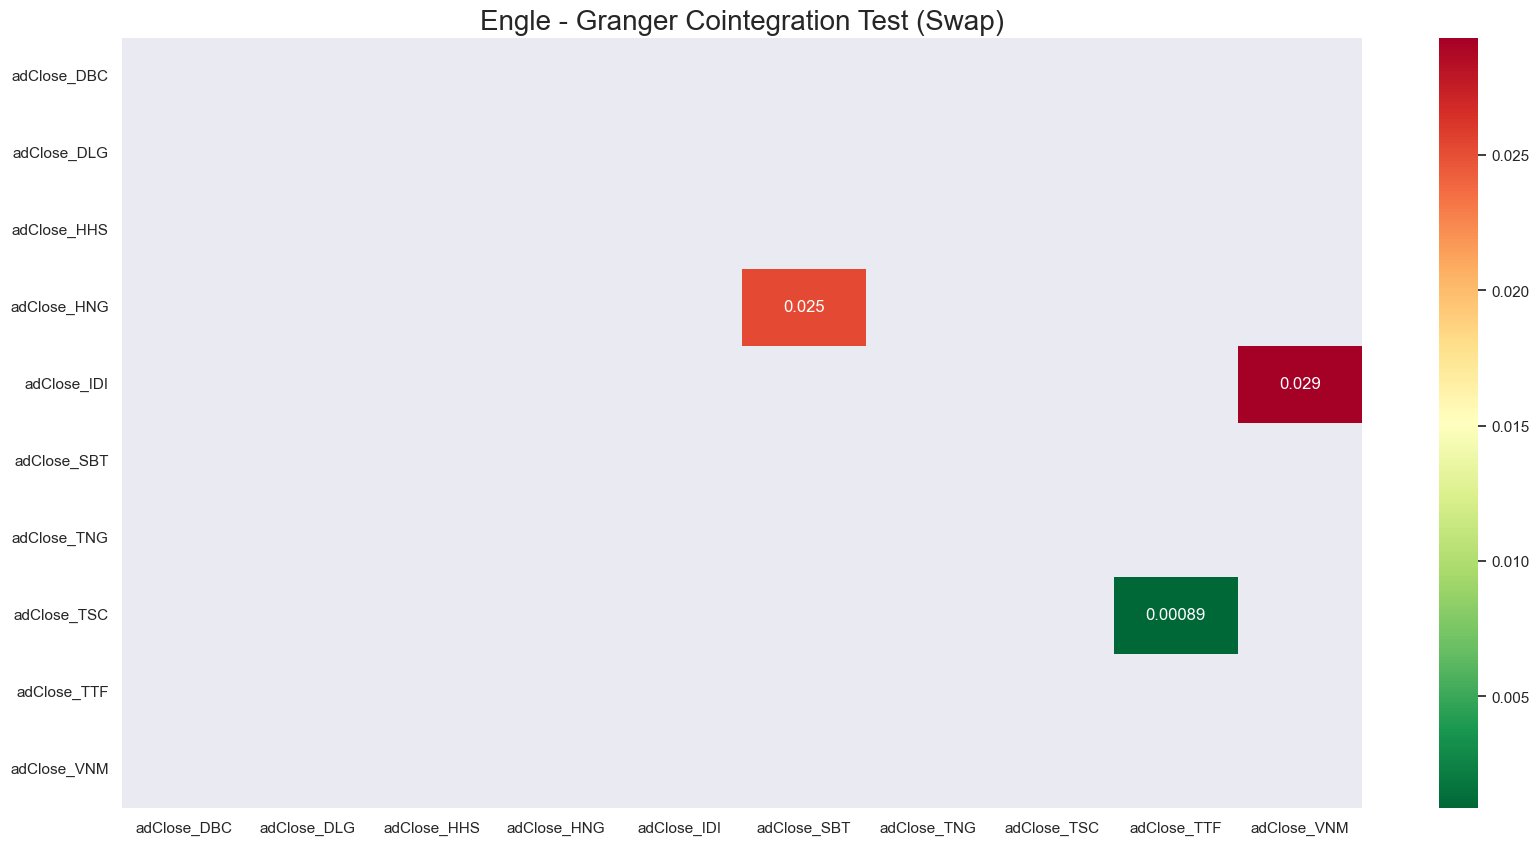

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [23]:
eg_pairs_swap

[['adClose_HNG', 'adClose_SBT'],
 ['adClose_IDI', 'adClose_VNM'],
 ['adClose_TSC', 'adClose_TTF']]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [25]:
johansen_pairs

[['adClose_DLG', 'adClose_TSC'],
 ['adClose_HHS', 'adClose_TSC'],
 ['adClose_IDI', 'adClose_VNM'],
 ['adClose_TSC', 'adClose_TTF'],
 ['adClose_TTF', 'adClose_VNM']]

# **Result Summary**

In [26]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [27]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_DBC,adClose_DLG,x,,,,1
1,adClose_DBC,adClose_HHS,x,,,,1
2,adClose_DBC,adClose_SBT,x,,,,1
3,adClose_DLG,adClose_HHS,x,,,,1
4,adClose_DLG,adClose_HNG,x,,,,1
5,adClose_DLG,adClose_TSC,,,,x,1
6,adClose_HHS,adClose_HNG,x,,,,1
7,adClose_HHS,adClose_SBT,x,,,,1
8,adClose_HHS,adClose_TSC,x,,,x,2
9,adClose_HNG,adClose_SBT,x,,x,,2


In [29]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//consumer_good//consumer_good_pairs_formation_third_period_{hdt.today_date_to_digits()}.csv"
    )